# Dependencies and Data Loading

In [1]:
import os
import sys
import time
import numpy as np
import random
import pandas as pd
import scipy.io as sio
from collections import Counter
from itertools import product
from scipy.io import loadmat
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras import optimizers,backend
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense, Flatten, Lambda, concatenate
from keras.layers.convolutional import Convolution1D,MaxPooling1D
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load training and ground truth data 
from scipy.io import loadmat

# synthetic training data
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Traindata_synthetic.mat'
input = loadmat(filename)
input_spectra = input['spectra_syn_train']
labels = input['pH_labels_syn_train']


In [5]:
# load testdata - synthetic spectra
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Testdata_synthetic.mat'
test_aug = loadmat(filename)
test_input_spectra_aug = test_aug['spectra_syn_test']
test_labels_aug = test_aug['pH_labels_syn_test']

# load testdata - kidney
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Testdata_kidney.mat'
test = loadmat(filename)
test_input_spectra = test['spectra_kidney_test']
test_labels = test['pH_labels_kidney_test']

In [6]:
display(test_input_spectra_aug.shape)
display(test_labels_aug.shape)
display(test_input_spectra.shape)
display(test_labels.shape)

(20, 1024)

(20, 3)

(8, 1024)

(8, 3)

# Preprocessing

In [7]:
#train-val split
X_train, X_val, y_train, y_val = train_test_split(input_spectra, labels, test_size=0.15, random_state=13)

X_train = np.array(X_train).astype('float32')
X_train = X_train.reshape(X_train.shape + (1,))
X_val = np.array(X_val).astype('float32')
X_val = X_val.reshape(X_val.shape + (1,))

X_test = np.array(test_input_spectra).astype('float32')
X_test = X_test.reshape(X_test.shape + (1,))
X_test_aug = np.array(test_input_spectra_aug).astype('float32')
X_test_aug = X_test_aug.reshape(X_test_aug.shape + (1,))

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(test_labels)
y_test_aug = np.array(test_labels_aug)

display(X_train.shape)
display(y_train.shape)

print("Total of "+str(len(X_train))+" training samples.")
print("Total of "+str(len(X_val))+" validation samples.")


(8500, 1024, 1)

(8500, 3)

Total of 8500 training samples.
Total of 1500 validation samples.


Total of 8500 training samples.
Total of 1500 validation samples.


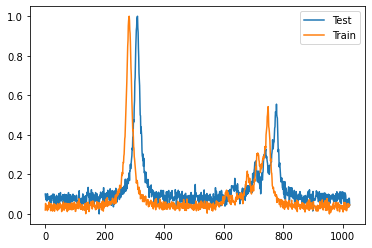

In [8]:
# print("Total of "+str(num_classes)+" classes.")
displayind = 2

print("Total of "+str(len(X_train))+" training samples.")
print("Total of "+str(len(X_val))+" validation samples.")
plt.plot(X_train[displayind],label='input')
plt.plot(X_val[displayind],label='ground truth')
plt.legend(['Test', 'Train'], loc='upper right')
plt.show()

# Model Architecture

In [9]:
def mapping_to_target_range( x, target_min=6.32, target_max=7.44) :
    x02 = backend.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

In [10]:
# default random initialization for weights
backend.clear_session()

model = Sequential()
activation = 'relu'
model.add(Dense(16, input_shape=(1024,1), activation='relu'))
model.add(MaxPooling1D())

model.add(Dense(16, activation='relu'))
model.add(MaxPooling1D())

model.add(Dense(32, activation='relu'))
model.add(MaxPooling1D())

model.add(Dense(32, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(3,activation=mapping_to_target_range))
nadam = optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=nadam)

print(model.summary())
print("MLP Model created.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024, 16)          32        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 512, 16)          0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 512, 16)           272       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 256, 16)          0         
 1D)                                                             
                                                                 
 dense_2 (Dense)             (None, 256, 32)           544       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 128, 32)          0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


# Training

In [11]:
#Params
epochs = 400
batch_size = 200

best_model_file = '/content/drive/My Drive/weights/KidNeYronal_model_mlp-s.h5'
start = time.time()

best_model = ModelCheckpoint(best_model_file, monitor='loss', verbose = 1, save_best_only=True, save_weights_only=False)
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_val, y_val),  
                 epochs=epochs,
                 batch_size=batch_size,
                 callbacks = [best_model],
                 shuffle = True,
                 verbose=1)

print("training time: ",time.time()-start)
print("done")

Epoch 1/400
43/43 [==============================] - ETA: 0s - loss: 0.0314
Epoch 00001: loss improved from inf to 0.03140, saving model to /content/drive/My Drive/weights/KidNeYronal_model_mlp-s.h5
43/43 [==============================] - 34s 711ms/step - loss: 0.0314 - val_loss: 0.0018
Epoch 2/400
43/43 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00002: loss improved from 0.03140 to 0.00184, saving model to /content/drive/My Drive/weights/KidNeYronal_model_mlp-s.h5
43/43 [==============================] - 1s 23ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/400
43/43 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00003: loss improved from 0.00184 to 0.00173, saving model to /content/drive/My Drive/weights/KidNeYronal_model_mlp-s.h5
43/43 [==============================] - 1s 22ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/400
43/43 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00004: loss improved from 0.00173 to 0.00165, s

(0.0, 0.01)

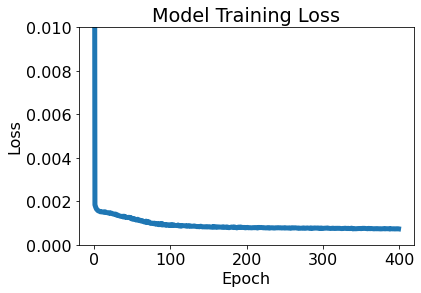

In [12]:
plt.rcParams.update({'font.size': 16})
plt.plot(hist.history['loss'], linewidth = 5)
plt.title('Model Training Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.01,bottom=0) 


(0.0, 0.005)

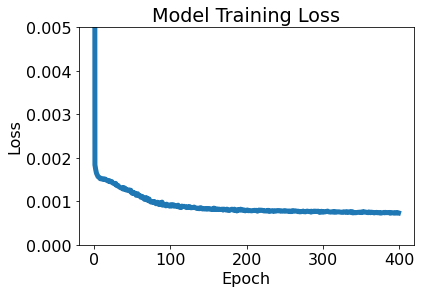

In [13]:
plt.plot(hist.history['loss'], linewidth = 5)
plt.title('Model Training Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.005,bottom=0) 

(0.0, 0.01)

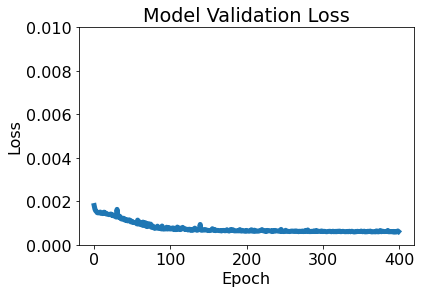

In [14]:
plt.plot(hist.history['val_loss'], linewidth = 5)
plt.title('Model Validation Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.01,bottom=0) 


(0.0, 0.005)

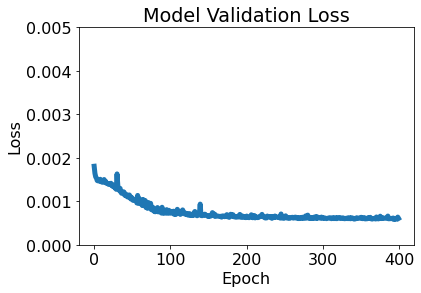

In [15]:
plt.plot(hist.history['val_loss'], linewidth = 5)
plt.title('Model Validation Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.005,bottom=0) 

# Testing Model Accuracy

In [16]:
predict = model.predict(X_test)
dis_index = 0     #index for the test data

In [17]:
def plot_predict_gt(predict_aug,y_test_aug):
  predict_output = pd.DataFrame({'predict':predict_aug,'ground truth':y_test_aug})
  predict_output = pd.DataFrame.transpose(predict_output)
  print('test: ',dis_index+1)
  print(predict_output)
  plt.figure()
  plt.plot(X_test[dis_index,:] )
  plt.title('spect= %i' %(dis_index+1))
  plt.ylabel('Intensity')
  print('\n')

test:  1
                     0         1         2
predict       7.386837  7.048204  6.755214
ground truth  7.429000  7.146000  6.739000


test:  2
                     0         1         2
predict       7.340264  7.027956  6.835915
ground truth  7.363000  7.103000  6.414000


test:  3
                     0         1         2
predict       7.353236  7.049346  6.858728
ground truth  7.332000  7.118000  6.381000


test:  4
                     0         1         2
predict       7.422341  7.076198  6.744566
ground truth  7.395000  6.970000  6.326000


test:  5
                    0         1         2
predict       7.43129  7.142857  6.960212
ground truth  7.35100  7.166000  6.750000


test:  6
                     0         1         2
predict       7.429321  7.122438  6.651381
ground truth  7.396000  7.045000  6.529000


test:  7
                     0       1        2
predict       6.738786  7.0713  6.66346
ground truth  7.431000  7.1500  6.76800


test:  8
                     0 

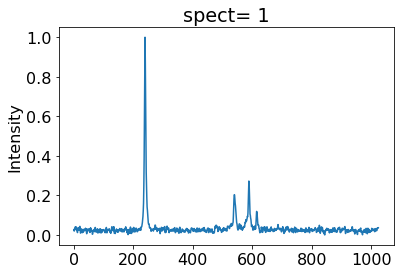

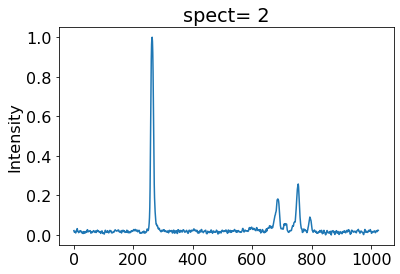

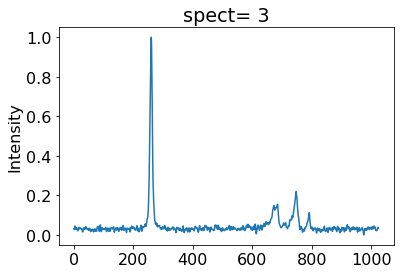

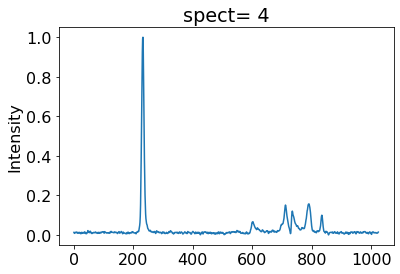

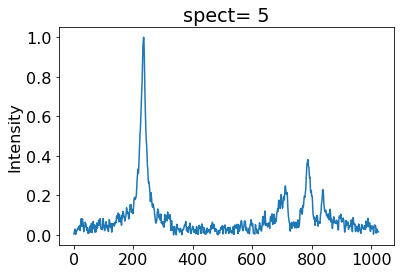

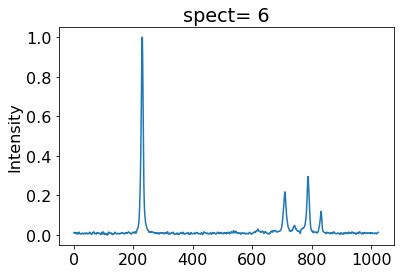

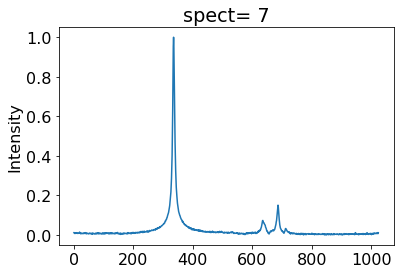

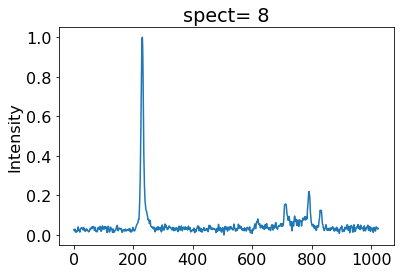

In [18]:
dis_index = 0
for idx in range(len(predict)):
  plot_predict_gt(predict[dis_index,:],y_test[dis_index,:])
  dis_index +=1

# Testing Model Accuracy - Synthetic data



In [19]:
predict_aug = model.predict(X_test_aug)

In [20]:
def print_predict_gt(predict_aug,y_test_aug):
  predict_output = pd.DataFrame({'predict':predict_aug,'ground truth':y_test_aug})
  predict_output = pd.DataFrame.transpose(predict_output)
  print('test: ',dis_index+1)
  print(predict_output)

In [21]:
dis_index = 0
for idx in range(len(predict_aug)):
  print_predict_gt(predict_aug[dis_index,:],y_test_aug[dis_index,:])
  dis_index +=1


test:  1
                     0         1         2
predict       7.384405  7.057750  6.500827
ground truth  7.366038  7.071987  6.522446
test:  2
                    0         1         2
predict       7.38638  7.069021  6.540631
ground truth  7.44000  7.006862  6.779162
test:  3
                     0         1         2
predict       7.388608  7.059159  6.518758
ground truth  7.367518  7.109335  6.486110
test:  4
                     0         1         2
predict       7.384007  7.063979  6.539958
ground truth  7.393396  7.006035  6.516890
test:  5
                     0         1         2
predict       7.390619  7.051356  6.472352
ground truth  7.405328  7.071277  6.422578
test:  6
                     0         1         2
predict       7.381419  7.060530  6.549490
ground truth  7.375795  7.023096  6.567435
test:  7
                     0         1         2
predict       7.386343  7.060539  6.472683
ground truth  7.400738  7.062025  6.364269
test:  8
                     0      